#Установка pyspark, импорт библиотек, создание структур и подготовка данных

In [459]:
#pip install pyspark

In [493]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, DoubleType, IntegerType, BooleanType
from pyspark.sql.functions import col, rand, when
from pyspark.ml.feature import VectorAssembler, StandardScaler, PolynomialExpansion
from pyspark.ml import Pipeline
from pyspark.ml.regression import LinearRegression, RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, TrainValidationSplit
from pyspark.ml.regression import GBTRegressor


#sc.setLogLevel("OFF")

spark = SparkSession.builder.appName("AbaloneAgePrediction").getOrCreate()

#Структура для инициализации
initSchema = StructType([
    StructField("Length", IntegerType(), True),
    StructField("Diameter", IntegerType(), True),
    StructField("Height", IntegerType(), True),
    StructField("WholeWeight", DoubleType(), True),
    StructField("ShuckedWeight", DoubleType(), True),
    StructField("VisceraWeight", DoubleType(), True),
    StructField("ShellWeight", DoubleType(), True),
    StructField("Sex_F", IntegerType(), True),
    StructField("Sex_I", IntegerType(), True),
    StructField("Sex_M", IntegerType(), True),
    StructField("Age", DoubleType(), True)
])

#
# goalSchema = StructType([
#     StructField("Length", IntegerType(), True),
#     StructField("Diameter", IntegerType(), True),
#     StructField("Height", IntegerType(), True),
#     StructField("WholeWeight", DoubleType(), True),
#     StructField("ShuckedWeight", DoubleType(), True),
#     StructField("VisceraWeight", DoubleType(), True),
#     StructField("ShellWeight", DoubleType(), True),
#     StructField("Age", DoubleType(), True),
#     StructField("Gen", IntegerType(), True)
# ])

df = spark.read.csv("train_dataset.csv", header=True, schema=initSchema)
# df = df.withColumn("Gen",
#                    when(df["Sex_F"]== 1, 0) \
#                    .when(df["Sex_I"]== 1, 1) \
#                    .when(df["Sex_M"]== 1, 2) \
#                    .otherwise(None))
# df = df.drop("Sex_F", "Sex_I", "Sex_M")
# df = spark.createDataFrame(df.rdd, goalSchema)


df.printSchema()
df.show(20)


root
 |-- Length: integer (nullable = true)
 |-- Diameter: integer (nullable = true)
 |-- Height: integer (nullable = true)
 |-- WholeWeight: double (nullable = true)
 |-- ShuckedWeight: double (nullable = true)
 |-- VisceraWeight: double (nullable = true)
 |-- ShellWeight: double (nullable = true)
 |-- Sex_F: integer (nullable = true)
 |-- Sex_I: integer (nullable = true)
 |-- Sex_M: integer (nullable = true)
 |-- Age: double (nullable = true)

+------+--------+------+-----------+-------------+-------------+-----------+-----+-----+-----+----+
|Length|Diameter|Height|WholeWeight|ShuckedWeight|VisceraWeight|ShellWeight|Sex_F|Sex_I|Sex_M| Age|
+------+--------+------+-----------+-------------+-------------+-----------+-----+-----+-----+----+
|   124|      97|    41|      243.8|         77.5|         50.1|       77.0|    0|    0|    1|14.0|
|   109|      88|    27|      183.7|         85.8|         40.3|       47.5|    1|    0|    0|10.0|
|   136|     108|    38|      324.6|        143.3|

In [494]:
nameColumns = ["Length",
              "Diameter",
              "Height",
              "WholeWeight",
              "ShuckedWeight",
              "VisceraWeight",
              "ShellWeight",
              "Sex_F",
              "Sex_I",
              "Sex_M"
              ]

assembler = VectorAssembler(inputCols=nameColumns, outputCol="features")

In [495]:
output = assembler.transform(df)
output.show(5, False)

+------+--------+------+-----------+-------------+-------------+-----------+-----+-----+-----+----+----------------------------------------------------+
|Length|Diameter|Height|WholeWeight|ShuckedWeight|VisceraWeight|ShellWeight|Sex_F|Sex_I|Sex_M|Age |features                                            |
+------+--------+------+-----------+-------------+-------------+-----------+-----+-----+-----+----+----------------------------------------------------+
|124   |97      |41    |243.8      |77.5         |50.1         |77.0       |0    |0    |1    |14.0|[124.0,97.0,41.0,243.8,77.5,50.1,77.0,0.0,0.0,1.0]  |
|109   |88      |27    |183.7      |85.8         |40.3         |47.5       |1    |0    |0    |10.0|[109.0,88.0,27.0,183.7,85.8,40.3,47.5,1.0,0.0,0.0]  |
|136   |108     |38    |324.6      |143.3        |70.8         |94.3       |0    |0    |1    |12.0|[136.0,108.0,38.0,324.6,143.3,70.8,94.3,0.0,0.0,1.0]|
|110   |88      |33    |172.1      |62.4         |33.8         |60.0       |0    |

**Scaler**

In [496]:
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withMean=True, withStd=True)
scalerModel = scaler.fit(output)
print(scalerModel)
scaledData = scalerModel.transform(output)
scaledData = scaledData.drop("features")
newDF = scaledData.withColumnRenamed("scaledFeatures", "features")
newDF.show(truncate=False)

StandardScalerModel: uid=StandardScaler_788c58a16d38, numFeatures=10, withMean=true, withStd=true
+------+--------+------+-----------+-------------+-------------+-----------+-----+-----+-----+----+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Length|Diameter|Height|WholeWeight|ShuckedWeight|VisceraWeight|ShellWeight|Sex_F|Sex_I|Sex_M|Age |features                                                                                                                                                                                                    |
+------+--------+------+-----------+-------------+-------------+-----------+-----+-----+-----+----+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

**Data Split**

In [497]:
weights = [0.7, 0.3]
train, test = newDF.randomSplit(weights, seed=42)
print("count train =", train.count(), "; count test =", test.count())

count train = 2541 ; count test = 1009


In [498]:
# test.orderBy("Age").show()
# train.orderBy("Age").show()

#Linear Regression

In [476]:
lr = LinearRegression(featuresCol="features", labelCol="Age")

m = lr.fit(train)
resultDF = m.transform(test)
resultDF.show(10)

+------+--------+------+-----------+-------------+-------------+-----------+-----+-----+-----+---+--------------------+------------------+
|Length|Diameter|Height|WholeWeight|ShuckedWeight|VisceraWeight|ShellWeight|Sex_F|Sex_I|Sex_M|Age|            features|        prediction|
+------+--------+------+-----------+-------------+-------------+-----------+-----+-----+-----+---+--------------------+------------------+
|    26|      19|     7|        2.1|          1.0|          1.3|        0.7|    0|    1|    0|4.0|[-3.2576119107307...| 4.503963914665325|
|    30|      20|     5|        3.0|          0.9|          0.8|        1.0|    0|    1|    0|2.0|[-3.0919334493463...| 4.552871952068742|
|    31|      22|     8|        3.1|          1.3|          0.6|        1.0|    0|    0|    1|3.0|[-3.0505138340002...| 5.691425185888726|
|    31|      23|     5|        4.8|          1.8|          1.0|        1.5|    0|    0|    1|5.0|[-3.0505138340002...|5.6645885272824446|
|    33|      22|     4|   

**Quality Rate of LinearRegression**

In [477]:
predictions = m.transform(test)

evaluator_rmse = RegressionEvaluator(labelCol="Age", predictionCol="prediction", metricName="rmse")
rmse = evaluator_rmse.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE) on test data = {rmse}")

Root Mean Squared Error (RMSE) on test data = 2.1553144479012243


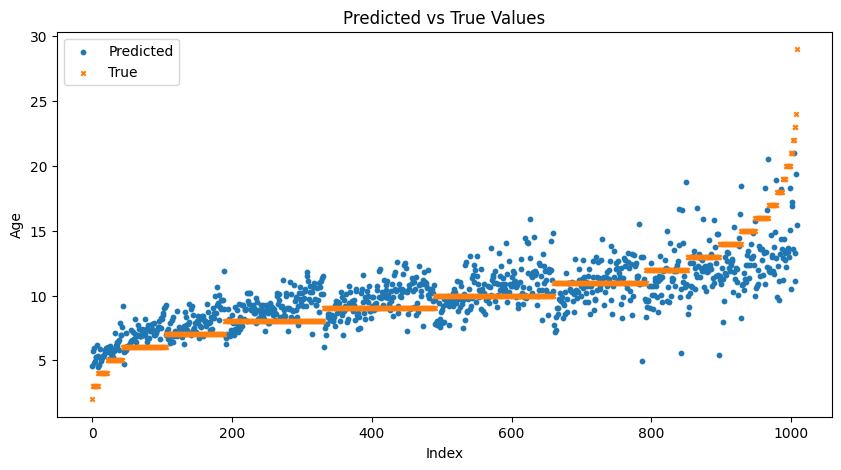

In [478]:
import matplotlib.pyplot as plt

predictions = resultDF.select("prediction", "Age").orderBy("Age").collect()
predicted_values = [row["prediction"] for row in predictions]
true_values = [row["Age"] for row in predictions]

plt.figure(figsize=(10, 5))
plt.scatter(range(len(predicted_values)), predicted_values, label="Predicted", marker='o', s=10)
plt.scatter(range(len(true_values)), true_values, label="True", marker='x', s=10)
plt.xlabel('Index')
plt.ylabel('Age')
plt.title('Predicted vs True Values')
plt.legend()
plt.show()

#DecisionTreeClassifier

In [406]:
from pyspark.ml.classification import DecisionTreeClassifier

lr = DecisionTreeClassifier(featuresCol="features", labelCol="Age")

m = lr.fit(train)
resultDF = m.transform(test)
resultDF.orderBy(rand()).show(10)

+------+--------+------+-----------+-------------+-------------+-----------+-----+-----+-----+----+--------------------+--------------------+--------------------+----------+
|Length|Diameter|Height|WholeWeight|ShuckedWeight|VisceraWeight|ShellWeight|Sex_F|Sex_I|Sex_M| Age|            features|       rawPrediction|         probability|prediction|
+------+--------+------+-----------+-------------+-------------+-----------+-----+-----+-----+----+--------------------+--------------------+--------------------+----------+
|    94|      75|    21|       88.2|         33.4|         17.3|       29.0|    0|    1|    0|10.0|[-0.4410780671955...|[0.0,0.0,0.0,0.0,...|[0.0,0.0,0.0,0.0,...|       8.0|
|   108|      83|    35|      179.5|         55.0|         48.2|       55.0|    1|    0|    0|14.0|[0.13879654764993...|[0.0,0.0,0.0,0.0,...|[0.0,0.0,0.0,0.0,...|      10.0|
|   106|      86|    27|      125.1|         49.0|         29.1|       42.7|    0|    1|    0|10.0|[0.05595731695772...|[0.0,0.0,0

**Quality Rate of DecisionTreeClassifier**

In [407]:
resultDF = m.transform(test)

predictions = m.transform(test)


evaluator_rmse = RegressionEvaluator(labelCol="Age", predictionCol="prediction", metricName="rmse")
rmse = evaluator_rmse.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE) on test data = {rmse}")

Root Mean Squared Error (RMSE) on test data = 2.481846877766213


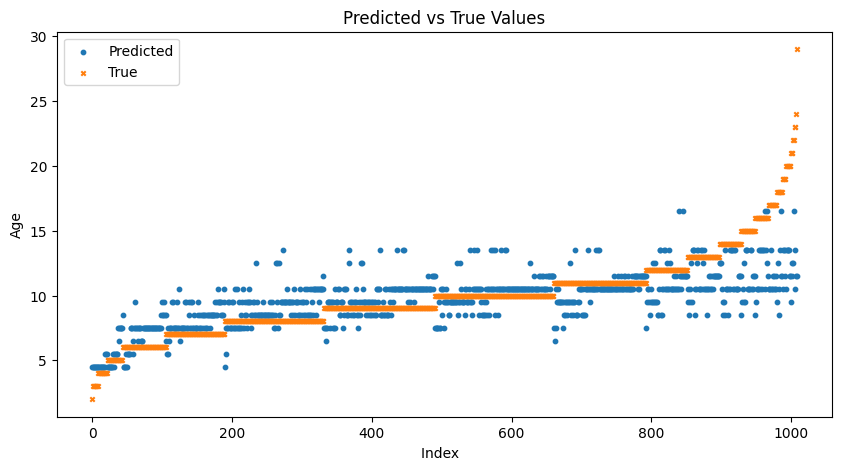

In [408]:
predictions = resultDF.select("prediction", "Age").orderBy("Age").collect()
predicted_values = [row["prediction"] + 0.5 for row in predictions]  # повысили высоту на 0.5 чтобы были видны
true_values = [row["Age"] for row in predictions]                    # пересечения на графике

plt.figure(figsize=(10, 5))
plt.scatter(range(len(predicted_values)), predicted_values, label="Predicted", marker='o', s=10)
plt.scatter(range(len(true_values)), true_values, label="True", marker='x', s=10)
plt.xlabel('Index  ')
plt.ylabel('Age')
plt.title('Predicted vs True Values')
plt.legend()
plt.show()

#RandomForest

In [452]:
from pyspark.ml.regression import RandomForestRegressor


# RandomForestRegressor модель
rf = RandomForestRegressor(featuresCol="features", labelCol="Age")

# Параметры GridSearch
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [10, 20, 50]) \
    .addGrid(rf.maxDepth, [5, 10, 15]) \
    .addGrid(rf.maxBins, [32, 64, 128]) \
    .build()

# Определение оценщика
evaluator = RegressionEvaluator(
    labelCol="Age", predictionCol="prediction", metricName="rmse")

# Перебор параметров с перекрёстной проверкой
cv = CrossValidator(estimator=rf,
                    estimatorParamMaps=paramGrid,
                    evaluator=evaluator,
                    numFolds=3)  # Количество фолдов

# Обучение модели
cvModel = cv.fit(train)

# Преминение обученной модели к тестовому набору данных
resultDF = cvModel.transform(test)

resultDF.orderBy(rand()).show(10)

+------+--------+------+-----------+-------------+-------------+-----------+-----+-----+-----+----+--------------------+------------------+
|Length|Diameter|Height|WholeWeight|ShuckedWeight|VisceraWeight|ShellWeight|Sex_F|Sex_I|Sex_M| Age|            features|        prediction|
+------+--------+------+-----------+-------------+-------------+-----------+-----+-----+-----+----+--------------------+------------------+
|   106|      83|    26|      168.5|         55.0|         38.9|       53.0|    0|    0|    1|20.0|[0.05595731695772...|12.563021451936299|
|   113|      91|    26|      211.6|         87.8|         52.9|       60.0|    1|    0|    0|10.0|[0.34589462438046...|11.378256227799602|
|    88|      75|    26|       97.4|         45.2|         19.3|       31.0|    0|    0|    1| 9.0|[-0.6895957592721...| 8.925536479862393|
|   130|     101|    33|      271.4|        114.5|         56.2|       86.0|    1|    0|    0|11.0|[1.05002808526426...|11.626648358404296|
|   114|      84|   

In [453]:
bestModel = cvModel.bestModel
print("Best Params:")
print("numTrees: ", bestModel.getNumTrees)
print("maxDepth: ", bestModel.getMaxDepth)
print("maxBins: ", bestModel.getMaxBins)

Best Params:
numTrees:  50
maxDepth:  <bound method _DecisionTreeParams.getMaxDepth of RandomForestRegressionModel: uid=RandomForestRegressor_6ba3a237bc6f, numTrees=50, numFeatures=10>
maxBins:  <bound method _DecisionTreeParams.getMaxBins of RandomForestRegressionModel: uid=RandomForestRegressor_6ba3a237bc6f, numTrees=50, numFeatures=10>


Quality Rate of RandomForest

In [454]:
predictions = bestModel.transform(test)

evaluator_rmse = RegressionEvaluator(labelCol="Age", predictionCol="prediction", metricName="rmse")
rmse = evaluator_rmse.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE) on test data = {rmse}")

Root Mean Squared Error (RMSE) on test data = 2.1041314395890796


  Без gridSearch'а получалось добиться RMSE только 2.25

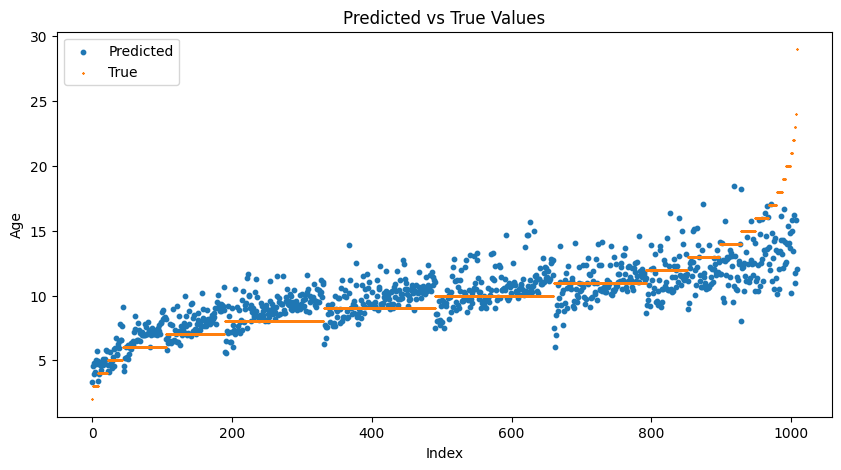

In [456]:
import matplotlib.pyplot as plt

predictions = resultDF.select("prediction", "Age").orderBy("Age").collect()
predicted_values = [row["prediction"] for row in predictions]
true_values = [row["Age"] for row in predictions]

plt.figure(figsize=(10, 5))
plt.scatter(range(len(predicted_values)), predicted_values, label="Predicted", marker='o', s=10)
plt.scatter(range(len(true_values)), true_values, label="True", marker='x', s=1)
plt.xlabel('Index')
plt.ylabel('Age')
plt.title('Predicted vs True Values')
plt.legend()
plt.show()

#PolynomialRegression

In [515]:
assembler = VectorAssembler(inputCols=["features"], outputCol="features_vector")
polynomial_expansion = PolynomialExpansion(inputCol="features", outputCol="poly_features", degree=2) # вручную проверено что 2 степень - лучший параметр
lr = LinearRegression(featuresCol="poly_features", labelCol="Age")

pipeline = Pipeline(stages=[assembler, polynomial_expansion, lr])

m = pipeline.fit(train)

resultDF = m.transform(test)

resultDF.show(10, truncate=False)

+------+--------+------+-----------+-------------+-------------+-----------+-----+-----+-----+---+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

assembler

**Quality Rate of PolynomialRegression**

In [516]:
predictions = m.transform(test)

evaluator_rmse = RegressionEvaluator(labelCol="Age", predictionCol="prediction", metricName="rmse")
rmse = evaluator_rmse.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE) on test data = {rmse}")

Root Mean Squared Error (RMSE) on test data = 2.0575738895637206


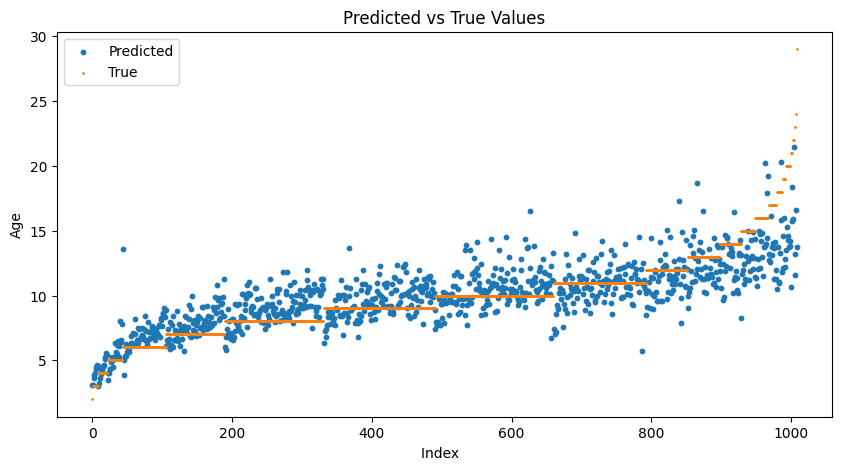

In [517]:
predictions = resultDF.select("prediction", "Age").orderBy("Age").collect()
predicted_values = [row["prediction"] for row in predictions]
true_values = [row["Age"] for row in predictions]

plt.figure(figsize=(10, 5))
plt.scatter(range(len(predicted_values)), predicted_values, label="Predicted", marker='o', s=10)
plt.scatter(range(len(true_values)), true_values, label="True", marker='x', s=1)
plt.xlabel('Index  ')
plt.ylabel('Age')
plt.title('Predicted vs True Values')
plt.legend()
plt.show()

#GBTRegressor

In [521]:
gbt = GBTRegressor(featuresCol="features", labelCol="Age")

# Определяем сетку параметров
paramGrid = ParamGridBuilder() \
    .addGrid(gbt.maxDepth, [5, 10, 15]) \
    .addGrid(gbt.maxBins, [32, 64]) \
    .addGrid(gbt.maxIter, [20, 50, 100]) \
    .build()

# Определяем оценщика
evaluator = RegressionEvaluator(
    labelCol="Age", predictionCol="prediction", metricName="rmse")

# Создание CrossValidator
crossval = CrossValidator(estimator=gbt,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5)  # Количество фолдов в кросс-валидации

# Обучение модели с использованием перекрестной проверки
cvModel = crossval.fit(train)

# Применение обученной модели к тестовому набору данных
resultDF = cvModel.transform(test)

# Выводим результаты
resultDF.show(10)

+------+--------+------+-----------+-------------+-------------+-----------+-----+-----+-----+---+--------------------+------------------+
|Length|Diameter|Height|WholeWeight|ShuckedWeight|VisceraWeight|ShellWeight|Sex_F|Sex_I|Sex_M|Age|            features|        prediction|
+------+--------+------+-----------+-------------+-------------+-----------+-----+-----+-----+---+--------------------+------------------+
|    26|      19|     7|        2.1|          1.0|          1.3|        0.7|    0|    1|    0|4.0|[-3.2576119107307...|3.6915496875036955|
|    30|      20|     5|        3.0|          0.9|          0.8|        1.0|    0|    1|    0|2.0|[-3.0919334493463...|3.6915496875036955|
|    31|      22|     8|        3.1|          1.3|          0.6|        1.0|    0|    0|    1|3.0|[-3.0505138340002...| 4.921434744974959|
|    31|      23|     5|        4.8|          1.8|          1.0|        1.5|    0|    0|    1|5.0|[-3.0505138340002...|3.6915496875036955|
|    33|      22|     4|   

In [526]:
bestModel = cvModel.bestModel
print("Best Params:")
print("MaxDepth: ", bestModel.getMaxDepth())
print("MaxBins: ", bestModel.getMaxBins())
print("MaxIter: ", bestModel.getMaxIter())

Best Params:
MaxDepth:  5
MaxBins:  64
MaxIter:  20


**Quality Rate of PolynomialRegression**

In [527]:
predictions = bestModel.transform(test)

evaluator_rmse = RegressionEvaluator(labelCol="Age", predictionCol="prediction", metricName="rmse")
rmse = evaluator_rmse.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE) on test data = {rmse}")

Root Mean Squared Error (RMSE) on test data = 2.3222585731752323


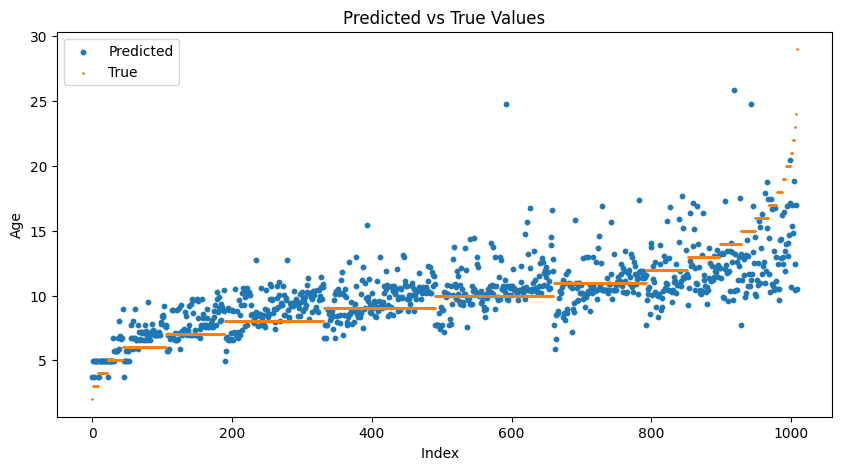

In [528]:
predictions = resultDF.select("prediction", "Age").orderBy("Age").collect()
predicted_values = [row["prediction"] for row in predictions]  # повысили высоту на 0.5 чтобы были видны
true_values = [row["Age"] for row in predictions]                    # пересечения на графике

plt.figure(figsize=(10, 5))
plt.scatter(range(len(predicted_values)), predicted_values, label="Predicted", marker='o', s=10)
plt.scatter(range(len(true_values)), true_values, label="True", marker='x', s=1)
plt.xlabel('Index  ')
plt.ylabel('Age')
plt.title('Predicted vs True Values')
plt.legend()
plt.show()